# Setup

In [40]:
import pandas as pd
import scanpy as sc
import scvelo as scv

In [41]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Read SCE

In [42]:
%%R -o adata -o hvgs
suppressPackageStartupMessages({
    library(scater)
    library(scran)
    library(tidyverse)
    library(logger)
})
sce <- readRDS("../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_tumor_D1220.rds")
log_info("Feature Selection...")
rowData(sce)$varm <- NULL
sce <- sce[calculateAverage(sce) > 1,]
sce <- sce[rowData(sce)$Biotype == 'protein_coding',]
colData(sce)<- colData(sce)[, !grepl("detected", colnames(colData(sce)))]
#reducedDim(sce, 'pca') <- NULL
metadata(sce) <- list()

keep <- rowData(sce)$Biotype == "protein_coding"
dec <- modelGeneVar(sce, subset.row = keep, min.mean = 1)
hvgs <- getTopHVGs(dec, n = 3000)
adata <- sce

R[write to console]: INFO [2021-06-17 10:30:37] Feature Selection...
R[write to console]: 



In [43]:
adata.var['highly_variable'] =  adata.var.index.isin(hvgs)
#sc.pp.neighbors(adata, n_pcs = 10,  use_rep = "X_pca" , n_neighbors = 10)

In [44]:
intSite = pd.read_csv("../04_HBV_integration/data/HBV_intSites.tsv", sep = '\t', index_col="cell.id")
intSite = intSite[['chrHuman', 'coordHuman', 'chrVir', 'coordVir', 'siteTypeHuman', 'geneHuman', 'siteClusters', 'siteHuman', 'representSites', 'representCellsInGroup']]
intSite = intSite.loc[intSite['representSites'] == "9:26713423",:]

In [45]:
adata.obs = adata.obs.join(intSite)

# Read Velocyto

In [46]:
adata_velo = sc.read("./data/anndata_velocyto_Smartseq2_scHCC-CD45_featureCounts_qc_clustered.h5ad")
adata_velo = adata_velo[adata.obs.index,:].copy()

# SCVelo pipeline

In [47]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo', dpi = 300)  # for beautified visualization

In [48]:
scv.pp.filter_genes(adata_velo, min_shared_counts=30)
scv.pp.normalize_per_cell(adata_velo)
scv.pp.filter_genes_dispersion(adata_velo, n_top_genes=2000, subset=False)
scv.pp.log1p(adata_velo)

adata_velo.obs['leiden'] = adata.obs['leiden'].astype("category")

Filtered out 49022 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.


In [49]:
adata_velo.var['velocity_genes'] = adata_velo.var.index.isin(hvgs)

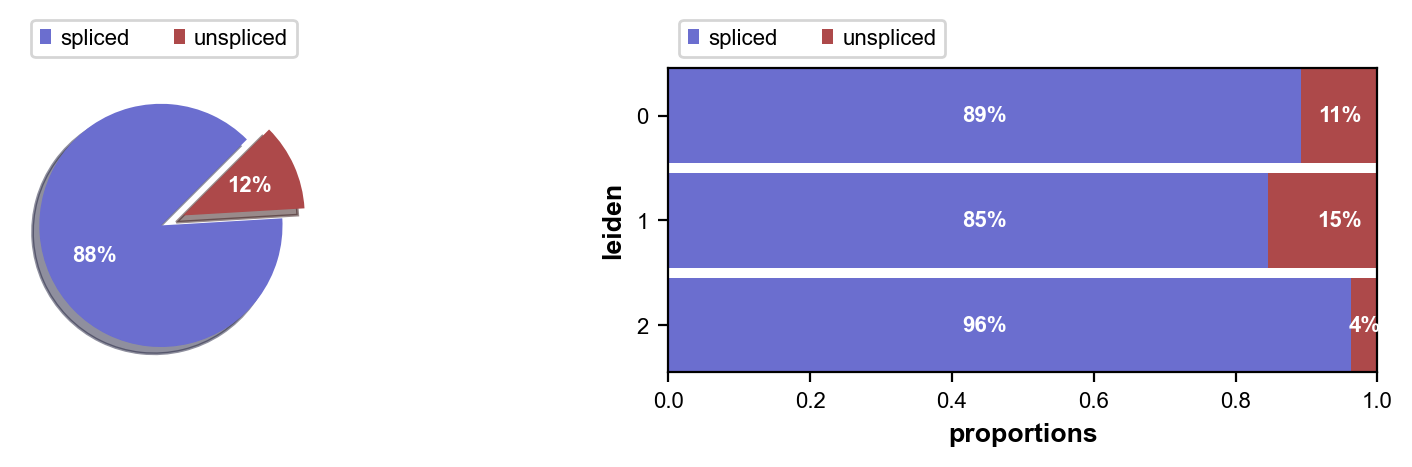

In [50]:
scv.pl.proportions(adata_velo, groupby = "leiden")

In [51]:
#adata_velo.obs = adata.obs
adata_velo.uns = adata.uns
adata_velo.obsm = adata.obsm

In [52]:
scv.pp.moments(adata_velo, n_pcs=50, use_rep="pca", n_neighbors=15)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Stochastic Model

In [1]:
scv.tl.velocity

NameError: name 'scv' is not defined

In [53]:
scv.tl.velocity(adata_velo)
scv.tl.velocity_graph(adata_velo)
scv.tl.velocity_pseudotime(adata_velo)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [63]:
emb_velo =  pd.read_csv("./emb_veloviz.tsv", sep = '\t', index_col='cell.id')

In [72]:
emb_velo

C1         C2
cell.id                               
TP5-10-20171220   72.734243  11.822683
TP5-13-20171220   67.700510  13.585502
TP5-201-20171220  71.163221   6.421888
TP5-208-20171220  76.877395  17.557687
TP5-209-20171220  68.640301  16.520083
...                     ...        ...
TP5-946-20171220  78.178275  13.858430
TP5-951-20171220  65.635583   8.462646
TP5-958-20171220  71.443333   4.056038
TP5-959-20171220  65.277516   6.522677
TP5-961-20171220  70.366766   5.394407

[158 rows x 2 columns]

In [77]:
adata_velo.obsm.update( X_veloviz = emb_velo[['C1','C2']].values)

In [75]:
adata_velo.obsm['X_pca']

array([[ 40.36991882,   5.44253683,  33.75240707, ...,   0.1388654 ,
        -24.80334854,  -8.22822762],
       [-33.30238342,  33.55015182, -22.57539749, ..., -34.4433136 ,
          6.74000311, -14.64862156],
       [ -3.50342965,  44.96087646, -45.89966965, ...,  15.5720911 ,
         11.3442173 ,  17.03645325],
       ...,
       [ 31.26191521,  16.36549759,  53.80385971, ...,  17.90614319,
        -19.18122292,  12.72230625],
       [-22.26501846,  43.59447098,   3.9799428 , ...,  -0.75372869,
        -15.32123661,   9.46187496],
       [-47.28659439,  17.00097084,  -2.92133379, ...,  -1.45981169,
        -14.52711296, -16.06193733]])

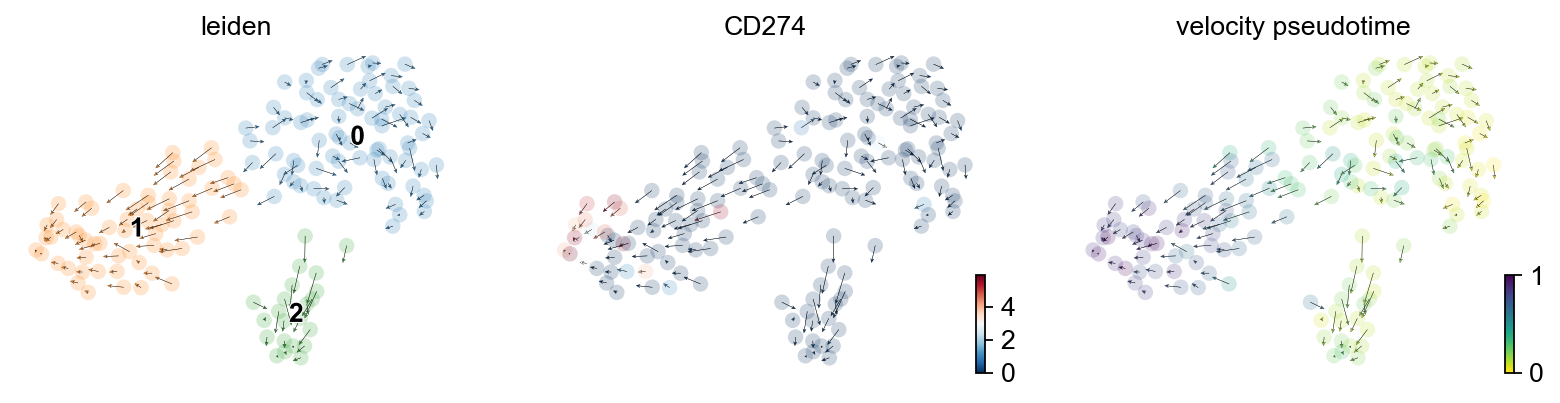

In [78]:
scv.pl.velocity_embedding(adata_velo, basis="umap", color=["leiden", 'CD274', 'velocity_pseudotime'], legend_loc="on data", arrow_length=1, arrow_size=1.5, dpi=200)

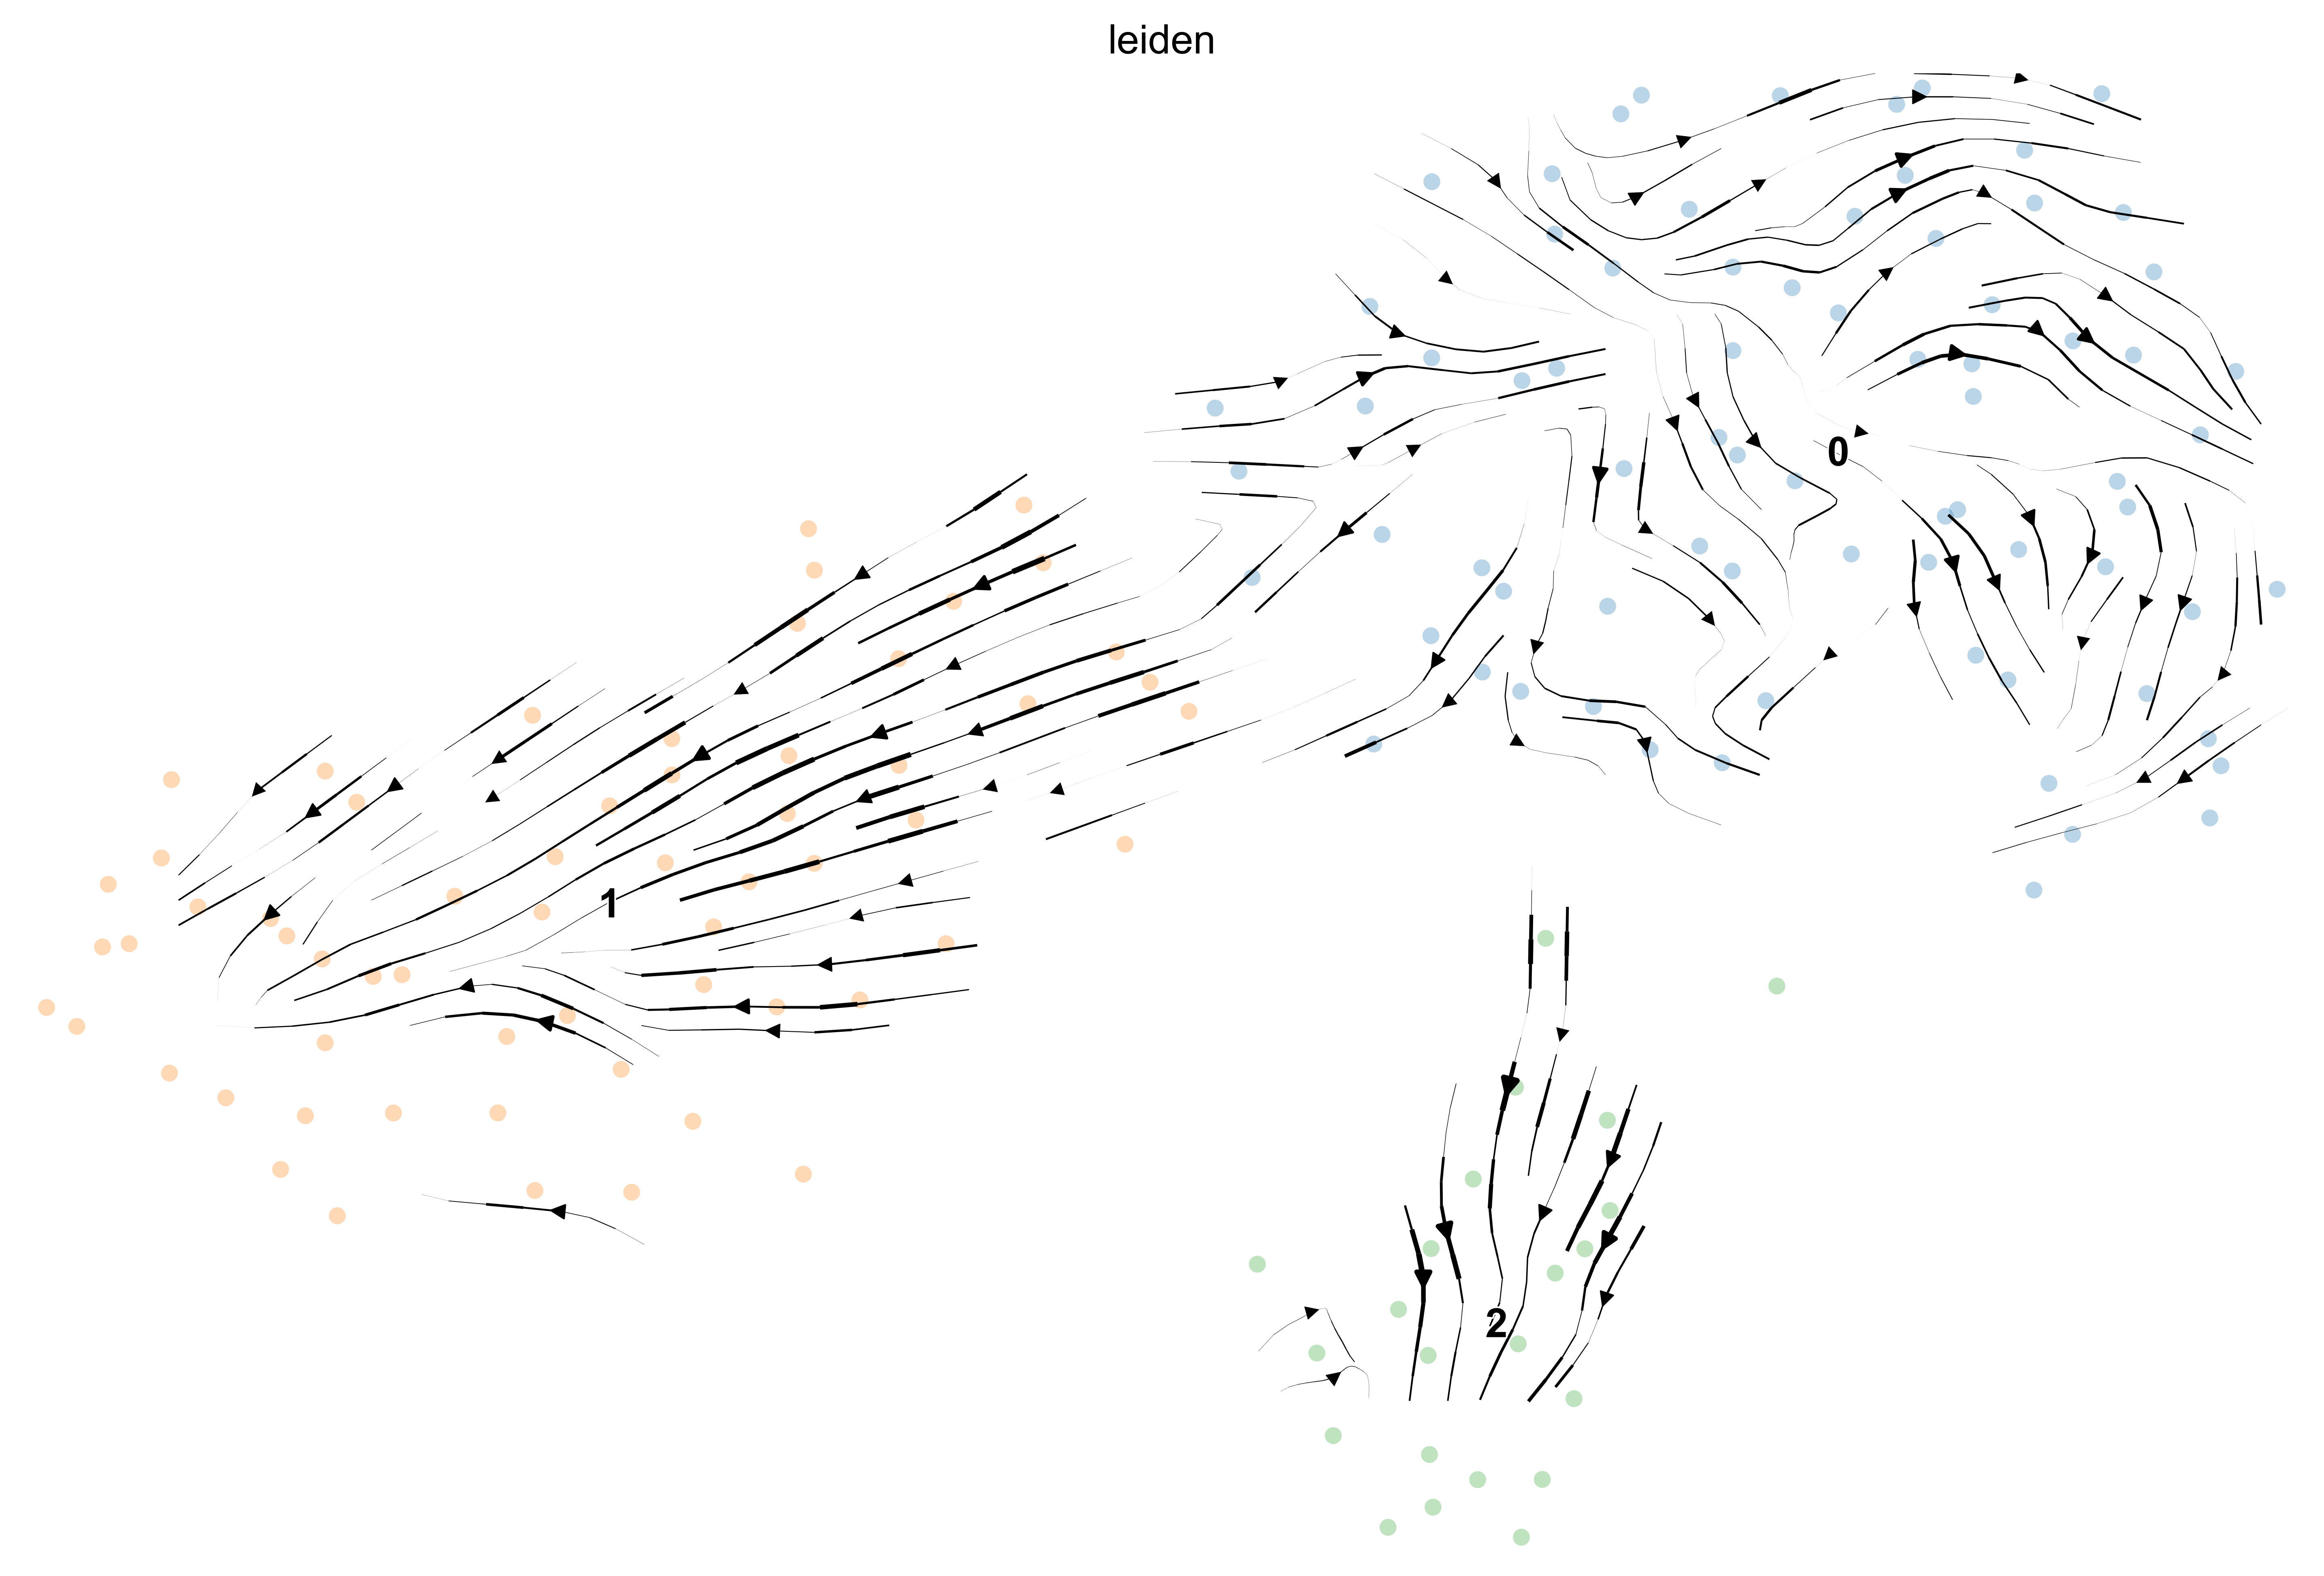

In [97]:
scv.pl.velocity_embedding_stream(adata_velo, basis='umap', color=["leiden"], linewidth = 1,size=100, cutoff_perc=10)

In [102]:
adata_velo.uns['leiden_colors'] = ['#899DA4', '#C93312', '#FAEFD1']

saving figure to file ./figures/scvelo_4F_velocity_strem.svg


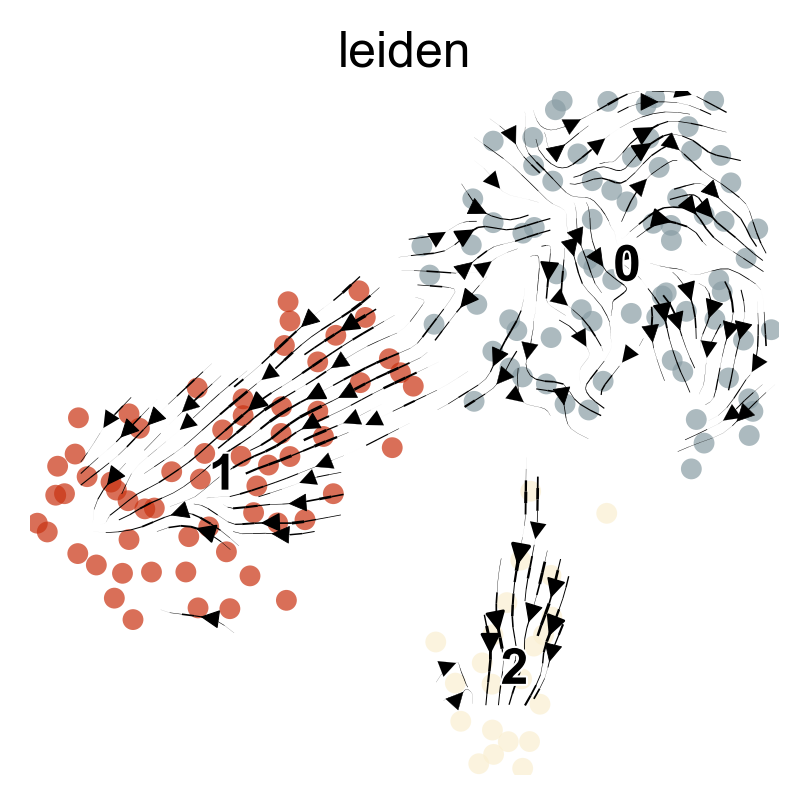

In [148]:
scv.pl.velocity_embedding_stream(adata_velo, basis='umap', color=["leiden"], density = 1, linewidth = .5,size=100, alpha = .7, 
                                 figsize=[3.2, 3],title = None, dpi = 150,
                                 cutoff_perc=10, save="4F_velocity_strem.svg")

saving figure to file ./figures/scvelo_4F_velocity_arrow.svg


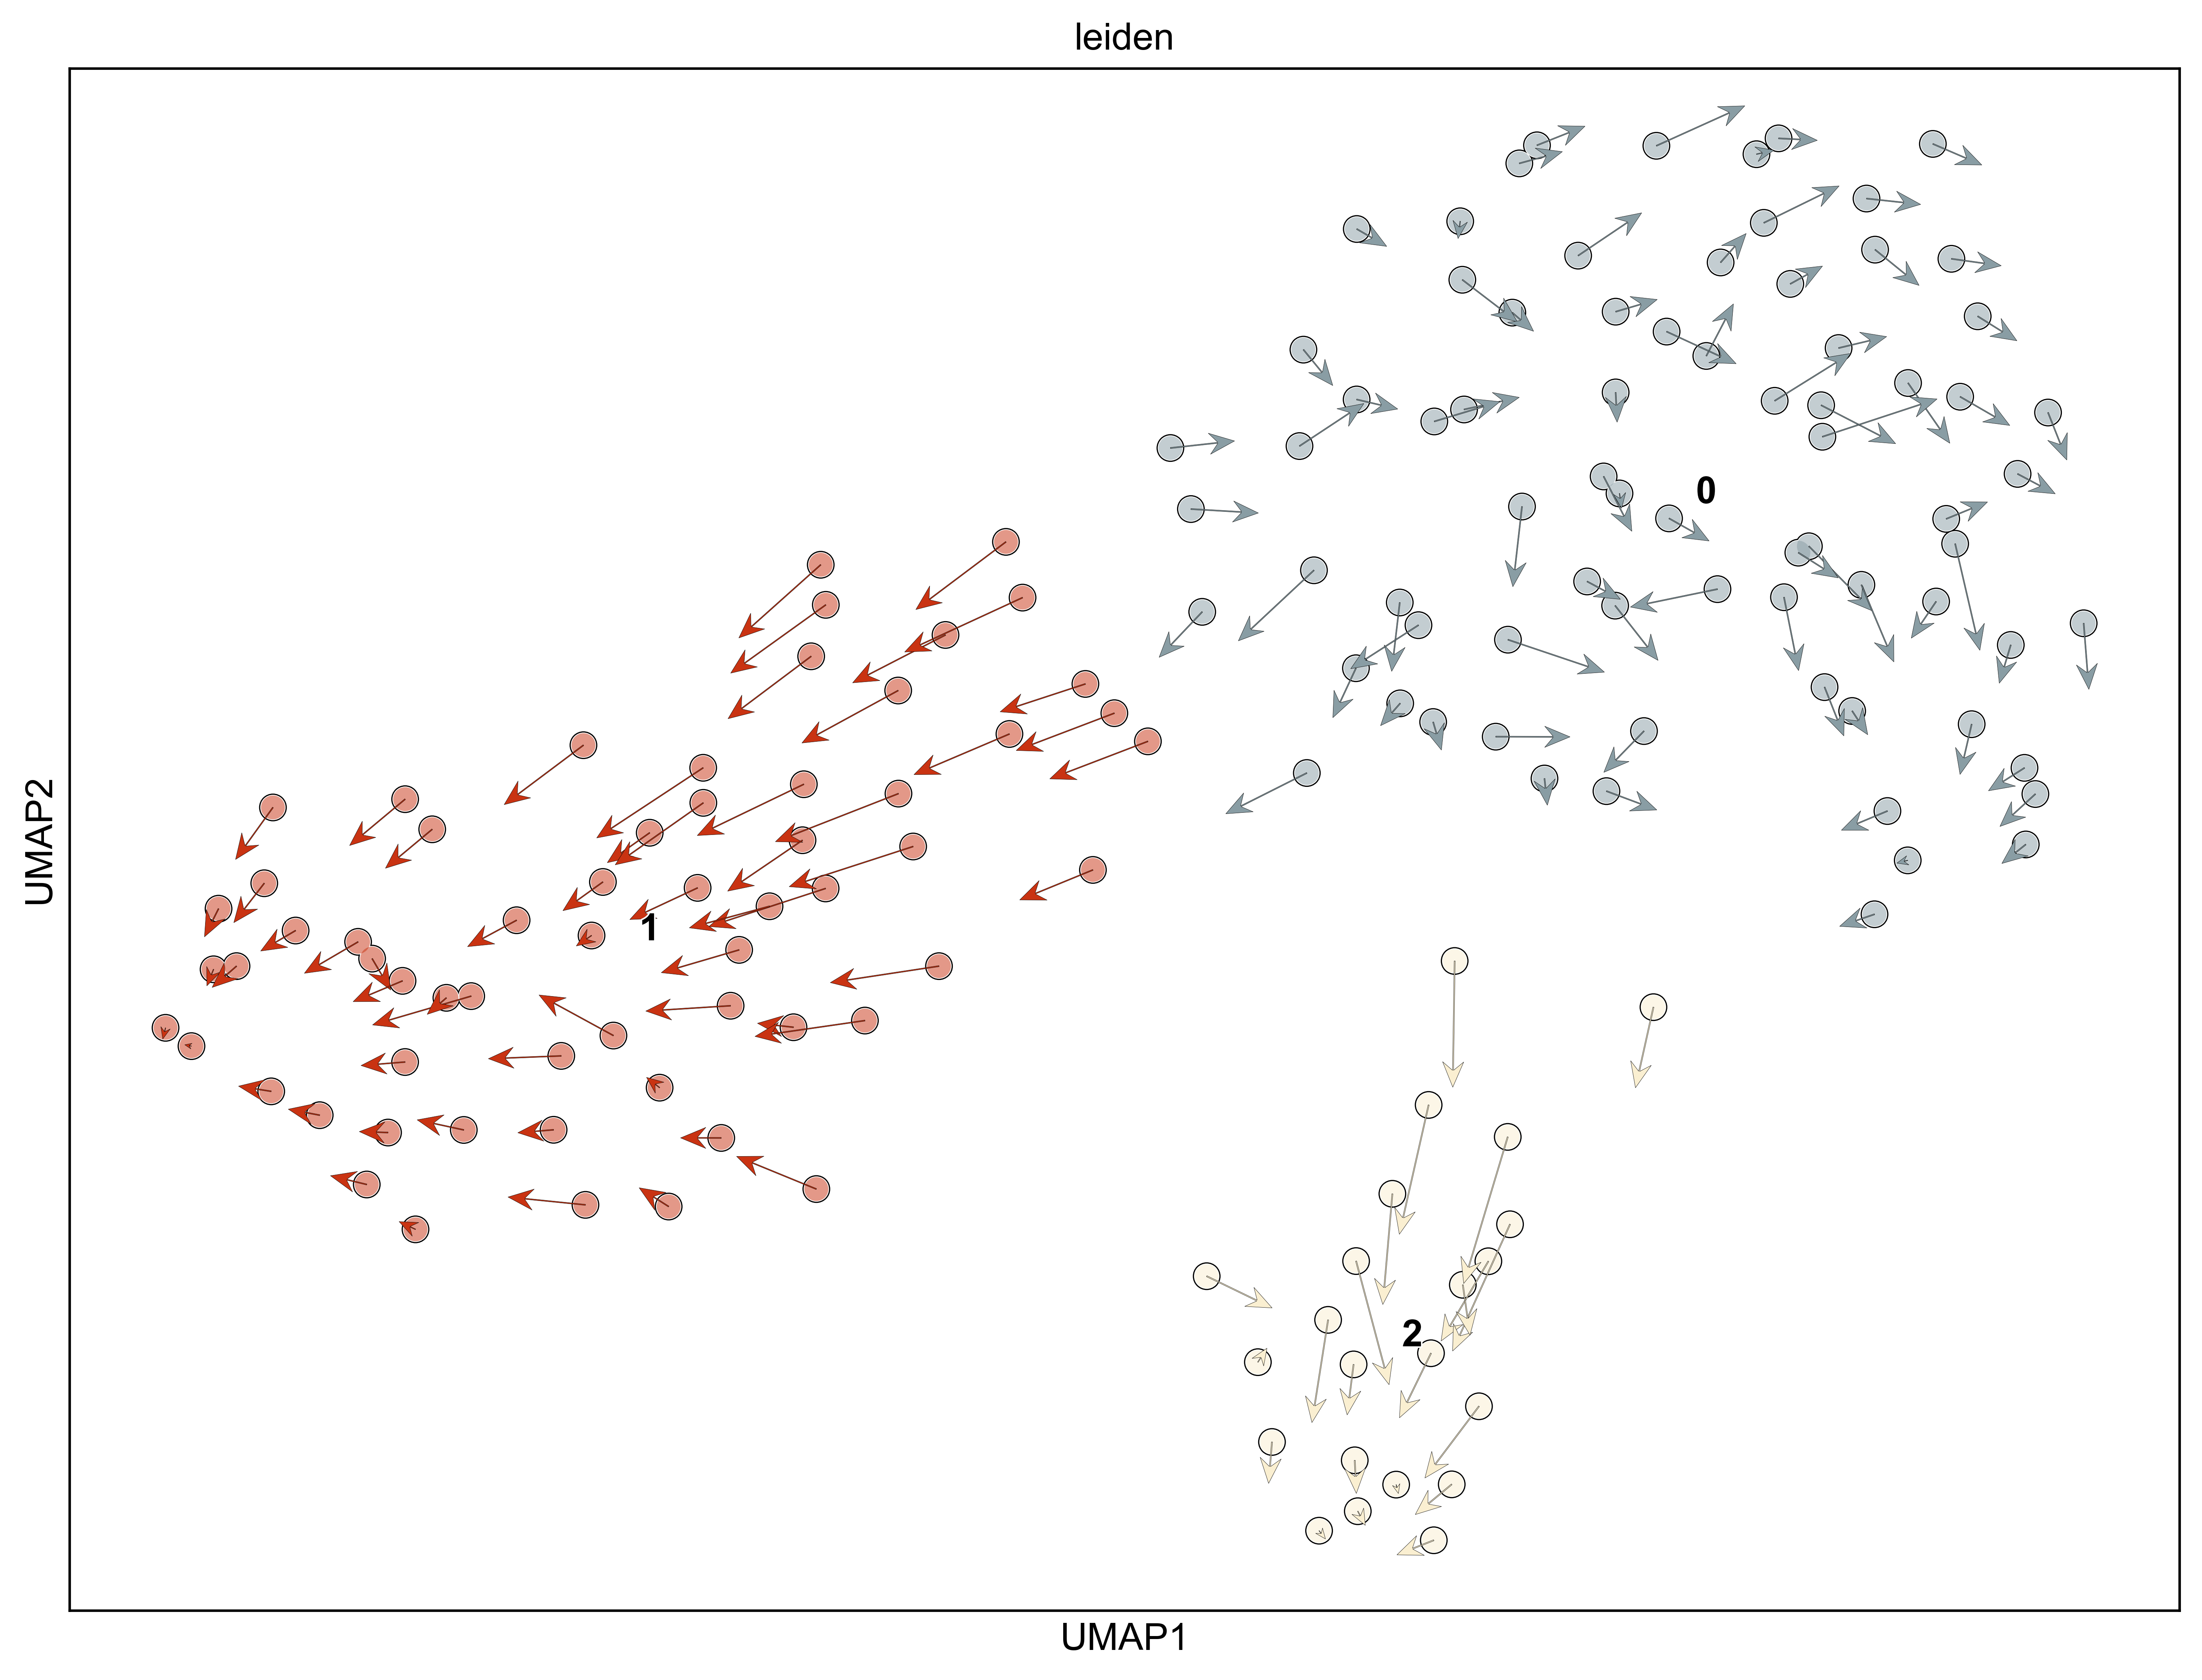

In [125]:
#scv.set_figure_params
scv.pl.velocity_embedding(adata_velo, basis='umap', color=["leiden"], 
                          add_outline = '0, 1, 2', outline_width = (0.05, 0.03), figsize=[4, 3],
                          legend_loc="on data", arrow_length=1, arrow_size=2,  frameon=True, alpha = .5, save="4F_velocity_arrow.svg")

In [56]:
adata_velo.write("anndata_velo_stochastic.h5ad")

In [68]:
# this is needed due to a current bug - bugfix is coming soon.
adata_velo.uns['neighbors']['distances'] = adata_velo.obsp['distances']
adata_velo.uns['neighbors']['connectivities'] = adata_velo.obsp['connectivities']

scv.tl.paga(adata_velo, groups='leiden')
df = scv.get_df(adata_velo, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


saving figure to file ./figures/scvelo_Figure2Emiddle_velocity_PAGA.pdf


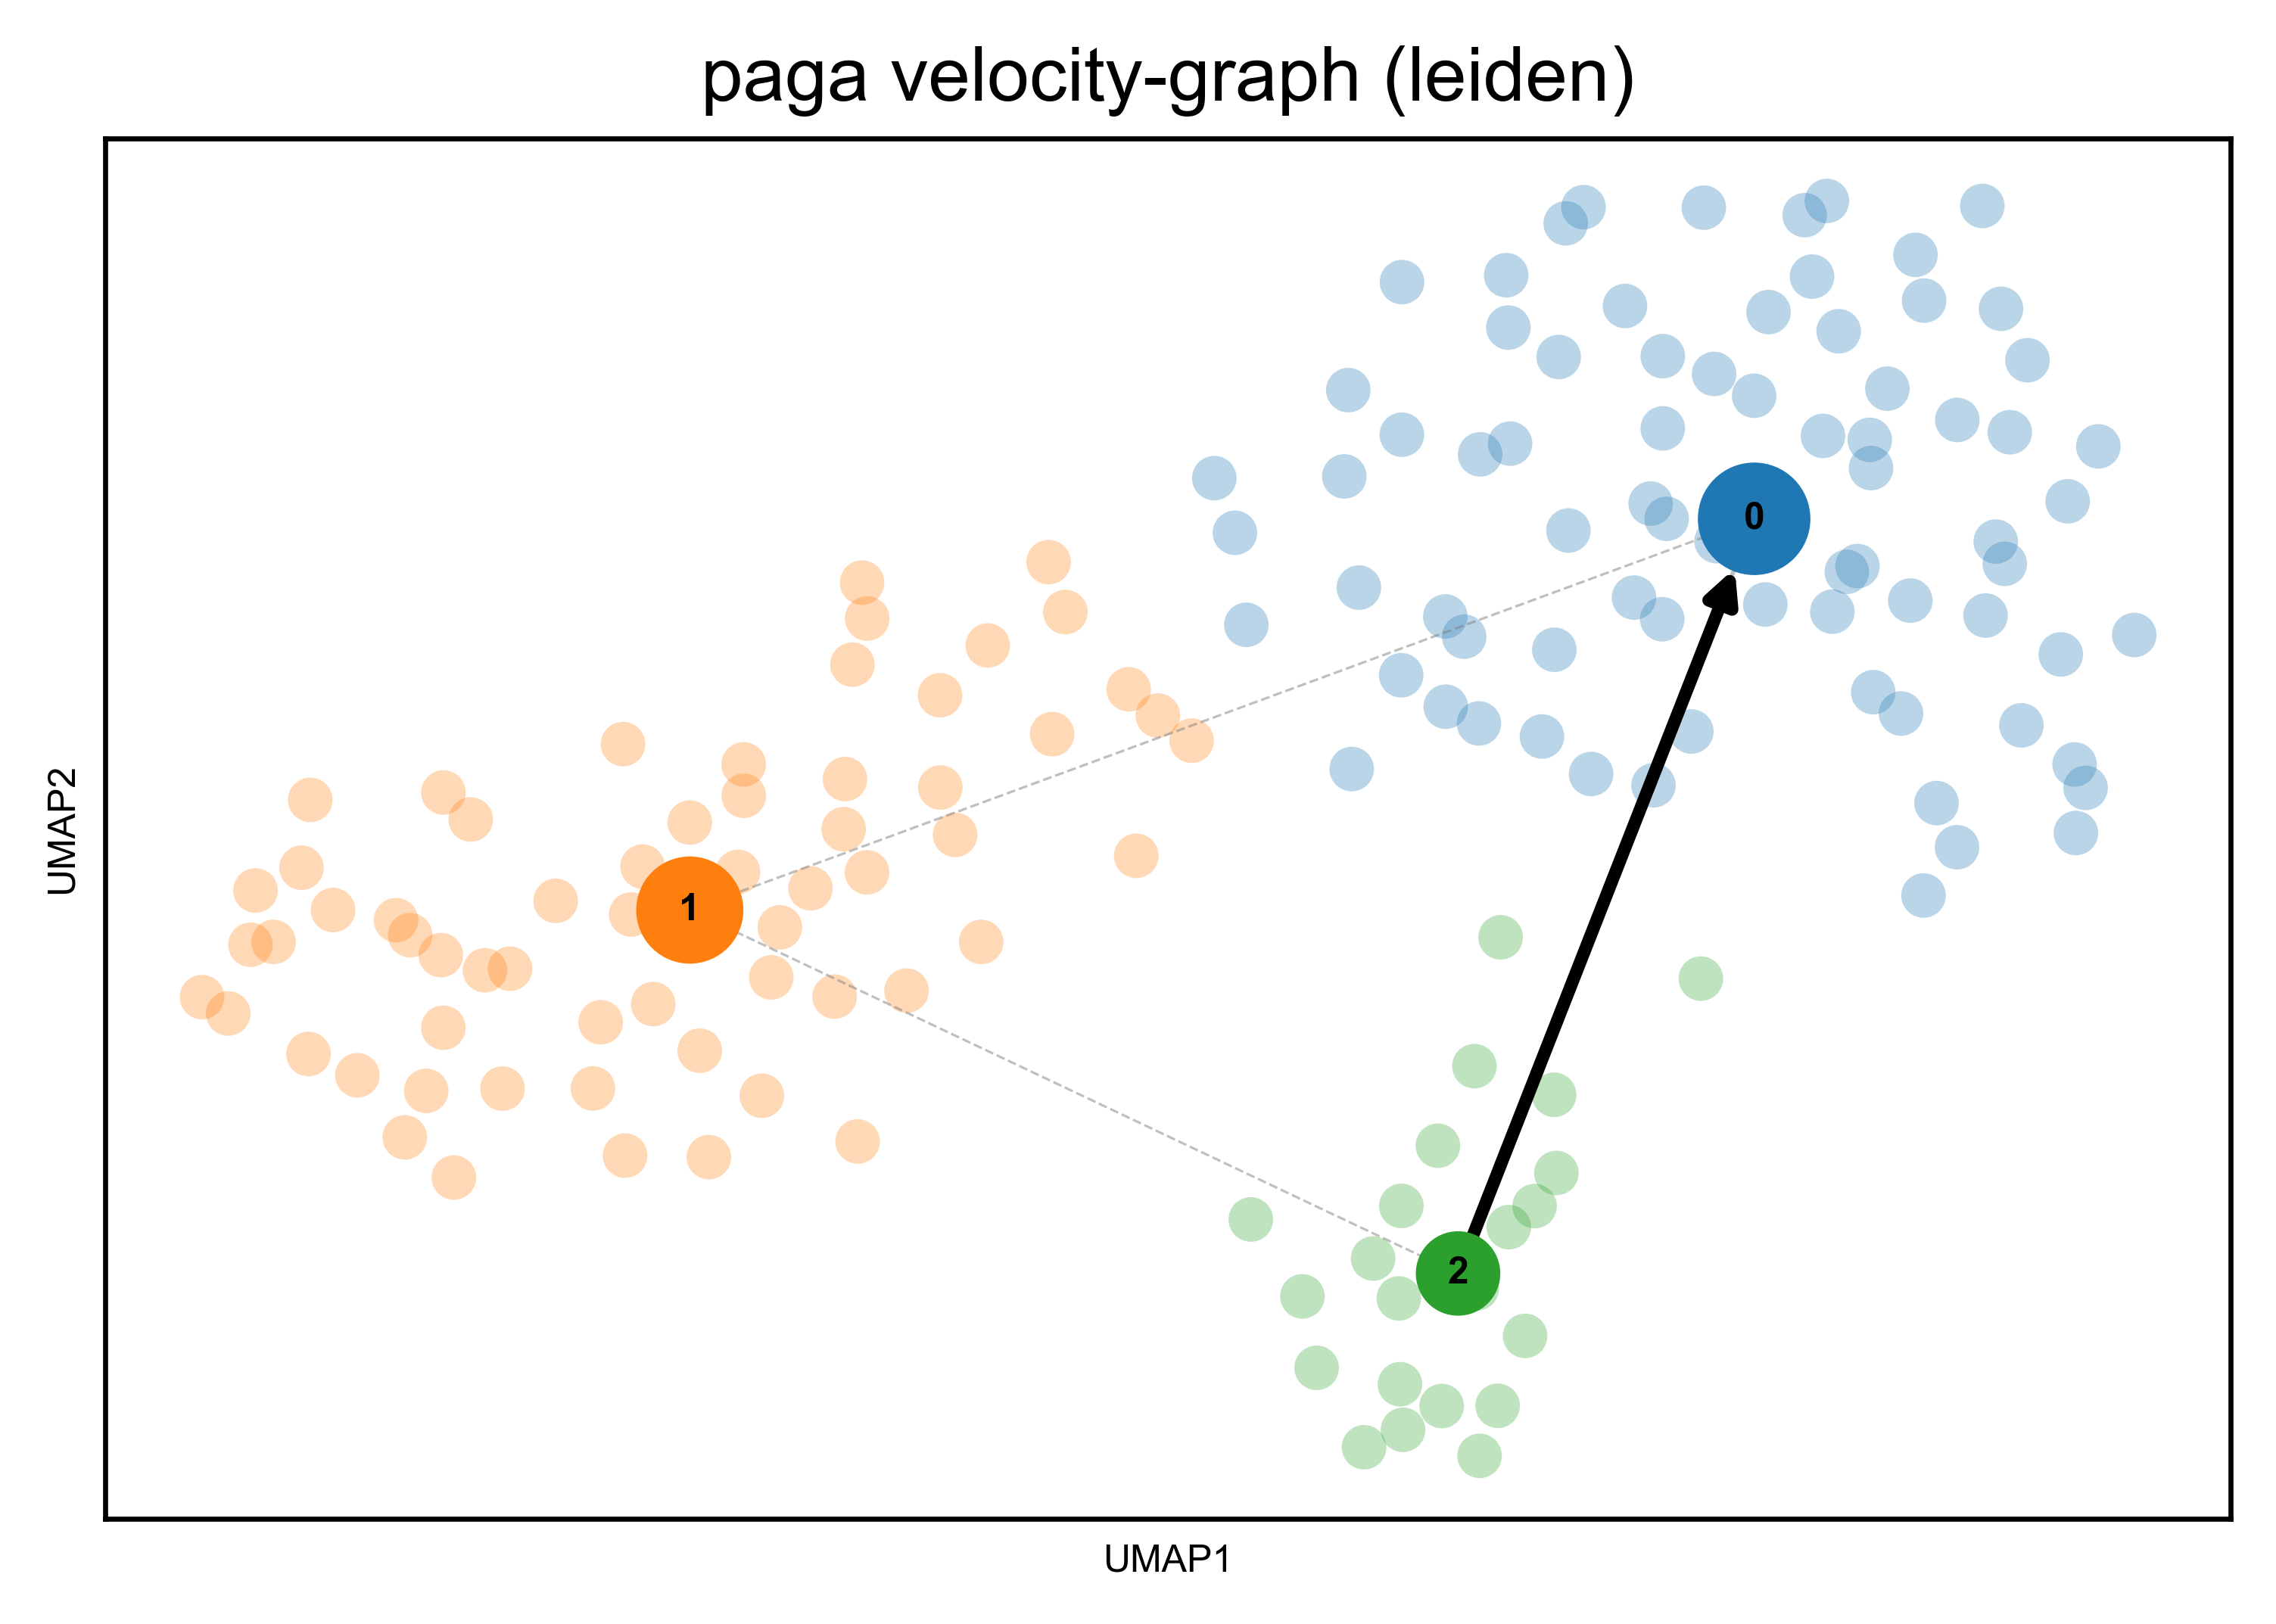

In [69]:
scv.pl.paga(adata_velo, basis='umap',  groups = 'leiden', legend_loc = 'on data', arrowsize = 10,
            color = ['leiden'], fontsize = 6, legend_fontoutline = 3, frameon = True,
            size=200, alpha=.3,outline_width = (0.05, 0.1), min_edge_width=2, node_size_scale=1.5, save="Figure2Emiddle_velocity_PAGA.pdf")



In [33]:
scv.tl.recover_dynamics(adata_velo, n_jobs=32)

recovering dynamics (using 32/72 cores)


  0%|          | 0/695 [00:00<?, ?gene/s]

    finished (0:00:07) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [34]:
scv.tl.velocity(adata_velo, mode = 'dynamical' )
scv.tl.velocity_graph(adata_velo)
scv.tl.velocity_pseudotime(adata_velo)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


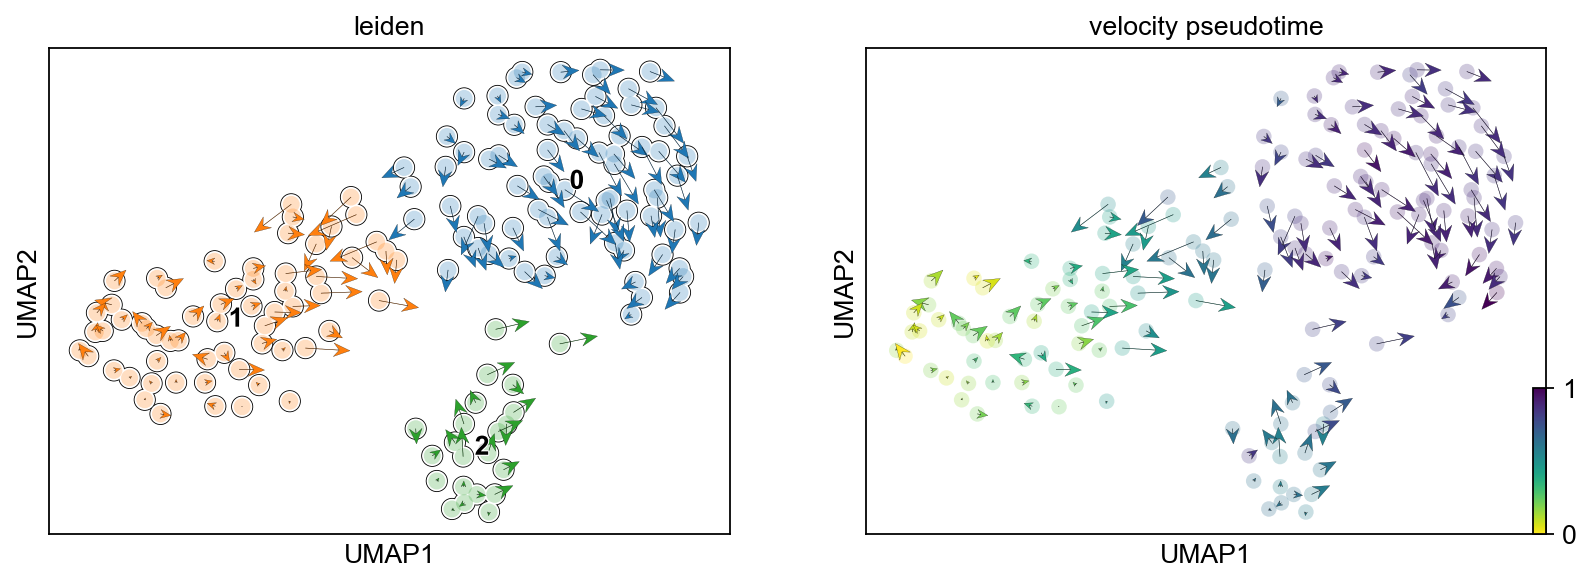

In [35]:
scv.pl.velocity_embedding(adata_velo, basis='umap', color=["leiden", 'velocity_pseudotime'], 
                          add_outline = '0, 1, 2', outline_width = (0.05, 0.1),
                          legend_loc="on data", arrow_length=1, arrow_size=4, dpi=200, frameon=True, alpha = .25)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


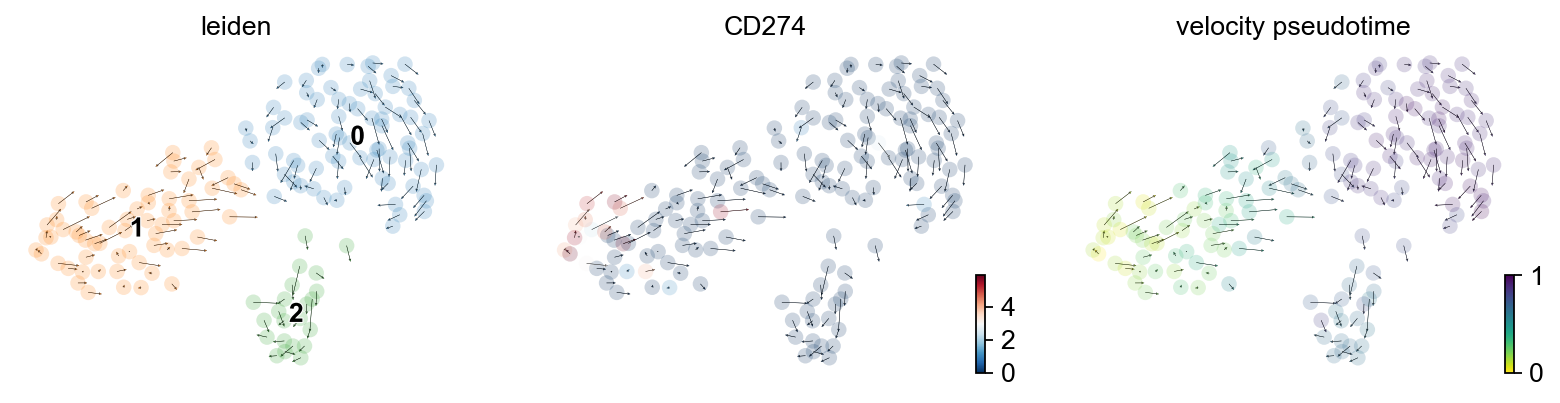

In [19]:
scv.pl.velocity_embedding(adata_velo, basis='umap', color=["leiden", 'CD274', 'velocity_pseudotime'], legend_loc="on data", arrow_length=1, arrow_size=1, dpi=200)

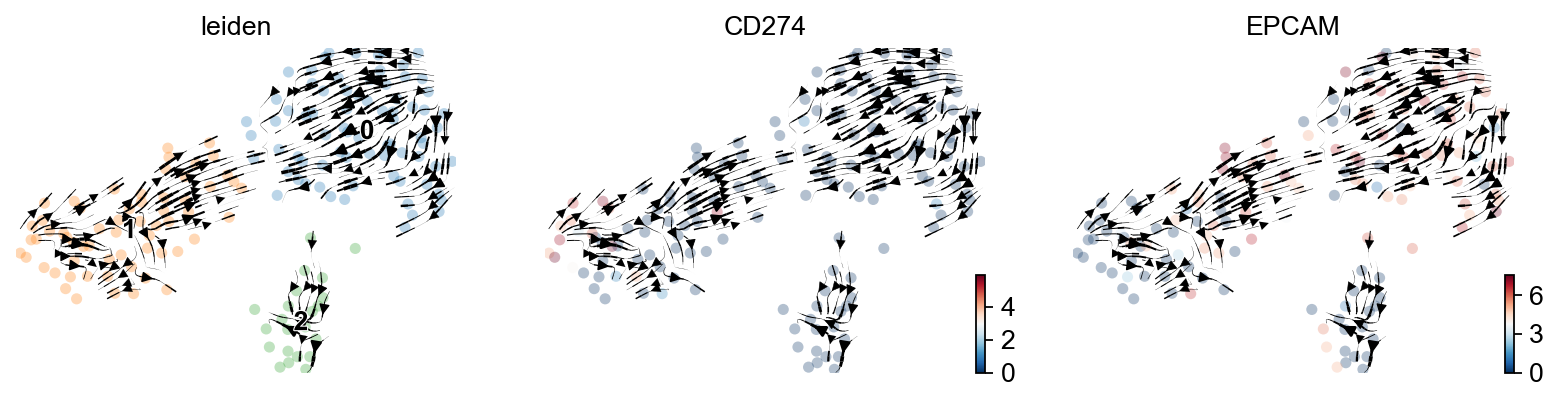

In [44]:
scv.pl.velocity_embedding_stream(adata_velo, basis='umap', color=["leiden", 'CD274', 'EPCAM'], size=100)